# Dealing with a small open-ocean segment with a lot of land cover

When addressing the challenge of removing cross-swath bias and error in areas with limited open-ocean and abundant land and coastlines, it's evident that an [ad-hoc approach](https://github.com/SWOT-community/SWOT-OpenToolkit/blob/main/examples/remove_crossswath_bias.ipynb) may lead to complications. In such scenarios, it becomes increasingly crucial to implement additional quality control measures. These measures are essential for identifying and eliminating erroneous data points, thereby enhancing the accuracy of the cross-swath bias removal process. Furthermore, this need for meticulous data curation partly explains the reduced precision of cross-over (xover) corrections in hydrology products, as of this writing, due to the scarcity of open-source data points in these regions.

The provided code below outlines the method for eliminating cross-swath error, but it's important to note that this process is based on a single snapshot. The small-scale Mean Sea Surface (MSS) variations, which are not represented in the current MSS product, persist. These variations might be mistakenly identified as submesoscale eddies!!! 

When handling data during the calibration and validation (calval) period, a straightforward solution could be the subtraction of the time-mean, a step not implemented in this notebook. However, for analyses of the science orbit phase, there currently isn't a ready-made solution. In such cases, the best approach is to await the development of a new, high-resolution Mean Sea Surface (MSS) product, which is expected to be enhanced by the SWOT KaRIn, as undertaken by the MSS working group.

The following code use Mediterrian Sea as an example. 

12/14/2023


['/mnt/flow/swot/KaRIn/SWOT_L2_LR_SSH_1.1/SWOT_L2_LR_SSH_Expert_502_016_20230426T062611_20230426T071233_PIB0_01.nc']

<xarray.Dataset>
Dimensions:                                (num_lines: 284, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude_nadir                         (num_lines) float64 41.0 ... 36.02
    longitude_nadir                        (num_lines) float64 1.652 ... 3.09
    latitude                               (num_lines, num_pixels) float64 41...
    longitude                              (num_lines, num_pixels) float64 2....
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/96)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    sea_state_bias_cor                     (num_lines, num_pixels) float32 ...
    sea_state_bias_cor_2                   (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 ...
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-08-17T14:35:59Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   JPL
    references:                                    V1.1
    equator_time:                                  2023-04-26T06:51:42.887000Z
    equator_longitude:                             9.61
    product_version:                               01

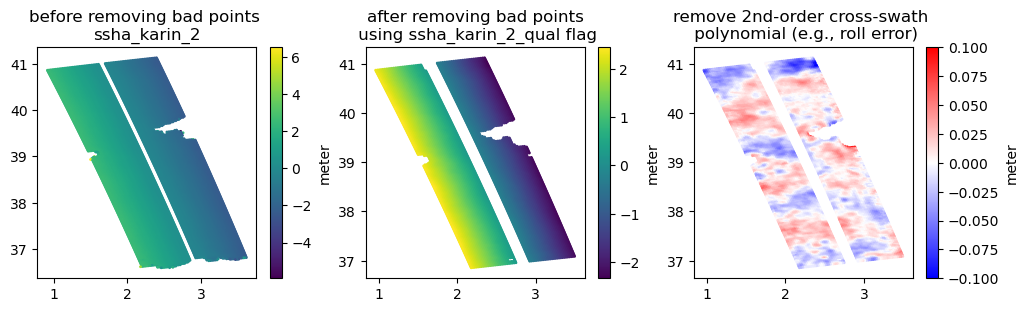

In [49]:
import pylab as plt
import numpy as np
import sys
sys.path.append('../src/')
import swot_ssh_utils as swot
from cartopy import crs as ccrs
from glob import glob 

pass_num='016'
pth = '/mnt/flow/swot/KaRIn/SWOT_L2_LR_SSH_1.1/' #path to your data
fn = f'SWOT_L2_LR_SSH_Expert_502_{pass_num}_20230426*PIB*.nc' #filename of your data
fns=sorted(glob(f'{pth}{fn}'))
display(fns)
# Latitude bounds
lat_bounds = [36, 41]


# Load data
data = swot.SSH_L2()
data.load_data(fns[0], lat_bounds=lat_bounds)
display(data.Expert)

# Preprocess data

flag = data.Expert.ancillary_surface_classification_flag
qual = data.Expert.ssha_karin_2_qual
ssha = np.where(flag==0, data.Expert.ssha_karin_2,np.nan) #open ocean only

#choose open ocean data points: data.Expert.ancillary_surface_classification_flag==0, 
# and high quality: data.Expert.ssha_karin_2_qual==0
ssha_clean = np.where(flag+qual == 0, ssha, np.nan)


lon = data.Expert.longitude.values
lat = data.Expert.latitude.values
distance = data.Expert.cross_track_distance.values

# Bias correction (optional)
ssha_clean_nobias = swot.fit_bias(
    ssha_clean, distance,
    check_bad_point_threshold=0.1,
    remove_along_track_polynomial=False
)

fig,axs=plt.subplots(1,3,figsize=(12,3))
cs0=axs[0].scatter(lon,lat,c=ssha,s=1)
axs[0].set_title('before removing bad points \nssha_karin_2')
plt.colorbar(cs0,ax=axs[0],label='meter')

cs1=axs[1].scatter(lon,lat,c=ssha_clean,s=1)
axs[1].set_title('after removing bad points\n using ssha_karin_2_qual flag')
plt.colorbar(cs1,ax=axs[1],label='meter')

cs1=axs[2].scatter(lon,lat,c=ssha_clean_nobias,s=1,vmin=-0.1,vmax=0.1,cmap='bwr')
axs[2].set_title('remove 2nd-order cross-swath \n polynomial (e.g., roll error)')
plt.colorbar(cs1,ax=axs[2],label='meter')



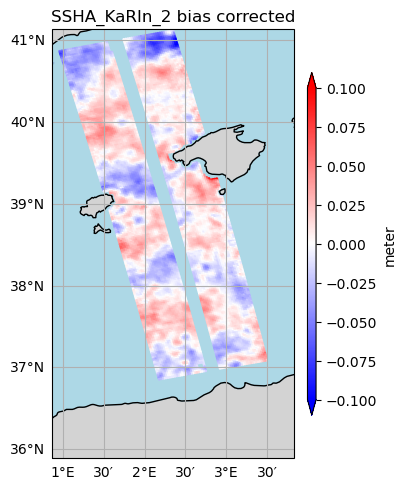

In [50]:
# Create plots using cartopy
fig, ax = plt.subplots(
    figsize=(7, 5),
    ncols=1,
    nrows=1,
    sharex=True,
    sharey=True,
    subplot_kw=dict(projection=ccrs.PlateCarree())
)

# Plot bias corrected data
swot.plot_a_segment(ax, lon, lat, ssha_clean_nobias, 
                    title='SSHA_KaRIn_2 bias corrected', 
                    vmin=-0.1, vmax=0.1)

# Save and display plot#
plt.tight_layout()
#plt.savefig('../media/figures/ssha_karin_2_california.png', dpi=100)